In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, GRU, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

'''
データ読み込み
'''
df = pd.read_csv('/code/data/JA_Dataset_240229.csv')

# 使用する列を選択
# df = df[['date', 'Week Start', 'Week End', 'Week Number', 'Shipment',
#        'Week Shipment', 'Teisyoku', 'Week Teisyoku', 'Temp', 'Week Temp',
#        'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP',
#        'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN',
#        'Week GLBRAD_30MIN', 'Status', 'Week Status']]

df = df[['date', 'Week Start', 'Week End', 'Week Number', 'Shipment',
       'Week Shipment', 'Temp', 'Week Temp',
       'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP',
       'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN',
       'Week GLBRAD_30MIN', 'Status', 'Week Status']]

'''
データの前処理
'''
# # dateの値を元にMonth列を作成
# df['Month'] = pd.to_datetime(df['date']).dt.month
# # 1~12月のカテゴリ変数を作成
# df['Month'] = df['Month'].astype('category')
# df = pd.get_dummies(df, columns=['Month'], dtype=int)

# Week Numberのそれぞれの値におけるWeek Shipmentの平均値を取得
Week_Shipment_Mean = df[:1670].groupby('Week Number')['Week Shipment'].mean().reset_index()
# Week Numberの値が等しい行にWeek Shipmentの平均値を結合
df['Week Shipment Mean'] = 0
for i in range(len(Week_Shipment_Mean)):
    df.loc[df['Week Number'] == Week_Shipment_Mean['Week Number'][i], 'Week Shipment Mean'] = Week_Shipment_Mean['Week Shipment'][i]

# Week Shipmentの値が0より大きい場合は1、それ以外は0のWeek Status2を作成
df['Week Status2'] = 0
df.loc[df['Week Shipment'] > 0, 'Week Status2'] = 1

# 既知のデータを2週間後のものに変更
df['Status'] = df['Status'].shift(-14)
df['Week Status'] = df['Week Status'].shift(-14)
df['Week Shipment Mean'] = df['Week Shipment Mean'].shift(-14)
df['Week Status2'] = df['Week Status2'].shift(-14)

# Week Status2が0の場合は0とする
df.loc[df['Week Status2'] == 0, 'Temp'] = 0
df.loc[df['Week Status2'] == 0, 'Week Temp'] = 0
df.loc[df['Week Status2'] == 0, 'High Temp'] = 0
df.loc[df['Week Status2'] == 0, 'Week High Temp'] = 0
df.loc[df['Week Status2'] == 0, 'Low Temp'] = 0
df.loc[df['Week Status2'] == 0, 'Week Low Temp'] = 0
df.loc[df['Week Status2'] == 0, 'AIRTMP'] = 0
df.loc[df['Week Status2'] == 0, 'Week AIRTMP'] = 0
df.loc[df['Week Status2'] == 0, 'GLBRAD'] = 0
df.loc[df['Week Status2'] == 0, 'Week GLBRAD'] = 0
df.loc[df['Week Status2'] == 0, 'GLBRAD_30MIN'] = 0
df.loc[df['Week Status2'] == 0, 'Week GLBRAD_30MIN'] = 0

# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINをshiftした列を作成
df['Temp' + str(-14)] = df['Temp'].shift(-14)
df['Week Temp' + str(-14)] = df['Week Temp'].shift(-14)
# df['High Temp' + str(-7)] = df['High Temp'].shift(-14)
# df['Week High Temp' + str(-14)] = df['Week High Temp'].shift(-14)
# df['High Temp' + str(-7)] = df['Low Temp'].shift(-14)
# df['Week Low Temp' + str(-14)] = df['Week Low Temp'].shift(-14)
# df['AIRTMP' + str(-14)] = df['AIRTMP'].shift(-14)
# df['Week AIRTMP' + str(-14)] = df['Week AIRTMP'].shift(-14)
df['GLBRAD' + str(-7)] = df['GLBRAD'].shift(-7)
df['Week GLBRAD' + str(-7)] = df['Week GLBRAD'].shift(-7)
# df['GLBRAD_30MIN' + str(-7)] = df['GLBRAD_30MIN'].shift(-7)
# df['Week GLBRAD_30MIN' + str(-7)] = df['Week GLBRAD_30MIN'].shift(-7)


# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINを削除
# df = df.drop(['Week Temp', 'Week High Temp', 'Week Low Temp', 'Week AIRTMP', 'Week GLBRAD', 'Week GLBRAD_30MIN'], axis=1)
df = df.drop(['Temp', 'Week Temp', 'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP', 'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD_30MIN'], axis=1)

# target列を追加
df['Target'] = df['Week Shipment'].shift(-14)
# Week Shipment列を先週の結果とする
df['Week Shipment'] = df['Week Shipment'].shift(7)

# 0~window_size分だけ各列をシフトし、新しい列として追加する
window_size = 0
shift_columns = ['Shipment']
# 元のDataFrameに対して、シフトされた列を一度に追加する
shifted_dfs = [df[shift_columns].shift(i).add_suffix(f'_{i}') for i in range(1, window_size + 1)]
new_df = pd.concat([df] + shifted_dfs, axis=1)
# 新しいDataFrameをコピーして、断片化を解消する
df = new_df.copy()

# Week Numberをカテゴリ変数に変換
df['Week Number'] = df['Week Number'].astype('category')
df = pd.get_dummies(df, columns=['Week Number'], dtype=int)

# 2019年以降のデータを使用
df = df[950:]

# dataに必要な部分だけ抜き出す
data = df[:-14]
data.drop(['date', 'Week Start', 'Week End', 'Week Status2', 'Week Shipment Mean'], axis=1, inplace=True)

'''
モデル入力のための加工（正規化、次元サイズ整理）
'''
scaler = MinMaxScaler()

# ターゲットベクトルの設定
y = df['Target'][window_size:-14].astype(float)
y = scaler.fit_transform(y.values.reshape(-1, 1)[:len(data)]).ravel()

# featuresの各列を正規化
normalized_features = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

print(len(y), len(normalized_features))

# 相関係数の大きい順にならべる
correlations = normalized_features.corrwith(normalized_features['Target'])
correlations = correlations.sort_values(ascending=False)
# print(correlations)
filtered_features = normalized_features[correlations.index]

# 平均値で欠損値を埋める
filtered_features.fillna(filtered_features.mean(), inplace=True)

# 特徴量をcsvとして保存
# filtered_features = filtered_features[['Target', 'Week Shipment', 'Week Status', 'Shipment', 'Week GLBRAD-7', 'GLBRAD-7', 'Status', 'Week Number_42', 'Week Number_39', 'Week Number_41', 'Week Number_43', 'Week Number_40', 'Week Number_38', 'Week Number_35', 'Week Number_37', 'Week Number_44', 'Week Number_36', 'Week Number_45', 'Week Temp-14', 'Temp-14', 'Week Number_46', 'Week Number_20', 'Week Number_34', 'Week Number_33', 'Week Number_19', 'Week Number_16', 'Week Number_17', 'Week Number_31', 'Week Number_22', 'Week Number_18', 'Week Number_30', 'Week Number_32', 'Week Number_15', 'Week Number_21', 'Week Number_25', 'Week Number_26', 'Week Number_24', 'Week Number_23', 'Week Number_27', 'Week Number_28', 'Week Number_29', 'Week Number_47', 'Week Number_13', 'Week Number_14', 'Week Number_12', 'Week Number_11', 'Week Number_53', 'Week Number_48', 'Week Number_10', 'Week Number_49', 'Week Number_9', 'Week Number_50', 'Week Number_8', 'Week Number_51', 'Week Number_1', 'Week Number_52', 'Week Number_2', 'Week Number_7', 'Week Number_6', 'Week Number_5', 'Week Number_4', 'Week Number_3']]
filtered_features.to_csv('/code/GRU_features.csv')
print(filtered_features.columns)

# Xとyにデータを格納
X = filtered_features.drop('Target', axis=1).values
y = filtered_features['Target'].values

# Xを3次元にリシェイプ
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

X_train = X_reshaped[:-469]
X_test = X_reshaped[-469:]
y_train = y[:-469]
y_test = y[-469:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


'''
モデルの訓練
'''
def train_and_evaluate_model(gru_units, dense_units):
    # model = Sequential()
    # model.add(GRU(units=gru_units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dense(units=dense_units, activation='relu'))
    # model.add(Dense(1, activation='relu'))
    # model.compile(optimizer='adam', loss='mean_squared_error')

    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    dense_layer = Dense(units=dense_units, activation='relu')(input_layer)
    gru_layer = GRU(units=gru_units, return_sequences=False)(dense_layer)
    output_layer = Dense(1, activation='relu')(gru_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, min_lr=0.000000001)

    # モデルの訓練
    history = model.fit(X_train, y_train, epochs=10000, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)
    
    # 検証データでの損失を評価
    val_loss = model.evaluate(X_test, y_test)
    print(f"GRU Units: {gru_units}, Dense Units: {dense_units}, Validation Loss: {val_loss}")

    return model, gru_units, dense_units, val_loss

# 結果を格納するための空のリストを作成
results = []
n = 1 # 繰り返しの回数

# 最良のモデルを追跡するための変数
best_params = {'gru_units': None, 'dense_units': None, 'val_loss': float('inf')}
best_model = None

# 異なるハイパーパラメータの組み合わせでモデルを訓練し評価
# for gru_units in [16, 32, 64, 128, 256]:
#     for dense_units in [16, 32, 64, 128, 256]:
#         val_loss = 99999999
#         for i in range(n):
#             result = train_and_evaluate_model(gru_units, dense_units)
#             print(result)
#             if val_loss > result[3]:
#                 val_loss = result[3]
#                 # 最良のモデルを更新
#                 if val_loss < best_params['val_loss']:
#                     best_params['gru_units'] = gru_units
#                     best_params['dense_units'] = dense_units
#                     best_params['val_loss'] = val_loss
#                     best_model = result[0]
#             print(f'val_loss: {val_loss}')
#         results.append(result)

for gru_units in [256, 512, 1024]:
    for dense_units in [256, 512, 1024]:
        val_loss = 99999999
        for i in range(n):
            result = train_and_evaluate_model(gru_units, dense_units)
            print(result)
            if val_loss > result[3]:
                val_loss = result[3]
                # 最良のモデルを更新
                if val_loss < best_params['val_loss']:
                    best_params['gru_units'] = gru_units
                    best_params['dense_units'] = dense_units
                    best_params['val_loss'] = val_loss
                    best_model = result[0]
            print(f'val_loss: {val_loss}')
        results.append(result)

print(results)

# 結果をDataFrameに変換
results_df = pd.DataFrame(results, columns=['model', 'GRU Units', 'Dense Units', 'Validation Loss'])

# 結果をCSVファイルに書き込む
results_df.to_csv('/code/gru_performance.csv', index=False)

# 最良のモデルのパラメータをファイル名に含めて保存
filename = f'/code/gru_best_model_gru{best_params["gru_units"]}_dense{best_params["dense_units"]}_loss{best_params["val_loss"]:.4f}.h5'
best_model.save(filename)

print(f"Saved the best model's results to {filename}")

/tmp/ipykernel_3586252/3741684097.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['date', 'Week Start', 'Week End', 'Week Status2', 'Week Shipment Mean'], axis=1, inplace=True)


1192 1192
Target           1.000000
Week Shipment    0.799455
Week Status      0.610962
Shipment         0.578208
Week GLBRAD-7    0.515100
                   ...   
Week Number_7   -0.201048
Week Number_6   -0.209528
Week Number_5   -0.213548
Week Number_4   -0.214070
Week Number_3   -0.214108
Length: 62, dtype: float64
Index(['Target', 'Week Shipment', 'Week Status', 'Shipment', 'Week GLBRAD-7',
       'GLBRAD-7', 'Status', 'Week Number_42', 'Week Number_39',
       'Week Number_41', 'Week Number_43', 'Week Number_40', 'Week Number_38',
       'Week Number_35', 'Week Number_37', 'Week Number_44', 'Week Number_36',
       'Week Number_45', 'Week Number_46', 'Week Number_20', 'Week Number_34',
       'Week Number_33', 'Week Temp-14', 'Temp-14', 'Week Number_19',
       'Week Number_16', 'Week Number_17', 'Week Number_31', 'Week Number_22',
       'Week Number_18', 'Week Number_30', 'Week Number_32', 'Week Number_15',
       'Week Number_21', 'Week Number_25', 'Week Number_26', 'Week Nu

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 70, 1)]           0         
                                                                 
 dense_10 (Dense)            (None, 70, 1024)          2048      
                                                                 
 gru_5 (GRU)                 (None, 512)               2362368   
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 2,364,929
Trainable params: 2,364,929
Non-trainable params: 0
_________________________________________________________________


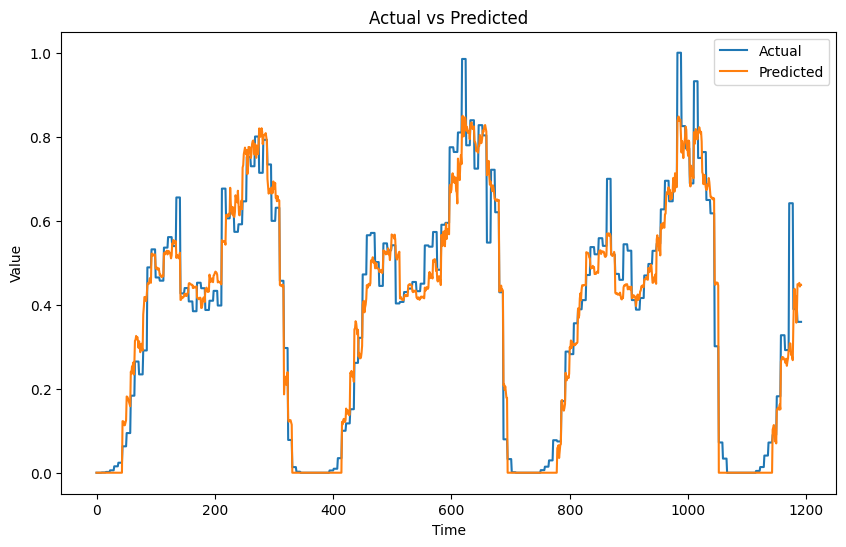

469
469


In [2]:
'''
モデルの推論
'''
# モデルの読み込み
from keras.models import load_model
current_model = load_model('/code/gru_best_model_gru512_dense1024_loss0.0046.h5')

current_model.summary()

y_pred = current_model.predict(X)
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# 予測結果の計算
y_pred = current_model.predict(X_test)
print(len(y_pred))
# testデータの予測結果をDataFrameに格納
# result = df[['date', 'Week Start', 'Week End', 'Week Number', 'Target']][-469-14:-14]
result = df[['date', 'Week Start', 'Week End', 'Target']][-469-14:-14]
print(len(result))
result['Pred'] = y_pred * df['Target'].max()
result.to_csv('/code/result.csv', index=False)

## 週出荷量をWeek Statusで割った値を予測

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, GRU, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

'''
データ読み込み
'''
df = pd.read_csv('/code/data/JA_Dataset_240229.csv')

# 使用する列を選択
df = df[['date', 'Week Start', 'Week End', 'Week Number', 'Shipment',
       'Week Shipment', 'Teisyoku', 'Week Teisyoku', 'Temp', 'Week Temp',
       'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP',
       'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN',
       'Week GLBRAD_30MIN', 'Status', 'Week Status']]

'''
データの前処理
'''
# # dateの値を元にMonth列を作成
# df['Month'] = pd.to_datetime(df['date']).dt.month
# # 1~12月のカテゴリ変数を作成
# df['Month'] = df['Month'].astype('category')
# df = pd.get_dummies(df, columns=['Month'], dtype=int)

# Week ShipmentをWeek Statusで割った列を作成
df['Target2'] = df['Week Shipment'] / df['Week Status']
df['Target2'] = df['Target2'].shift(-14)
df['Target2'] = df['Target2'].fillna(0)

# Week Numberのそれぞれの値におけるWeek Shipmentの平均値を取得
Week_Shipment_Mean = df[:1670].groupby('Week Number')['Week Shipment'].mean().reset_index()
# Week Numberの値が等しい行にWeek Shipmentの平均値を結合
df['Week Shipment Mean'] = 0
for i in range(len(Week_Shipment_Mean)):
    df.loc[df['Week Number'] == Week_Shipment_Mean['Week Number'][i], 'Week Shipment Mean'] = Week_Shipment_Mean['Week Shipment'][i]

# Week Shipmentの値が0より大きい場合は1、それ以外は0のWeek Status2を作成
df['Week Status2'] = 0
df.loc[df['Week Shipment'] > 0, 'Week Status2'] = 1

# 既知のデータを2週間後のものに変更
df['Status'] = df['Status'].shift(-14)
df['Week Status'] = df['Week Status'].shift(-14)
df['Week Shipment Mean'] = df['Week Shipment Mean'].shift(-14)
df['Week Status2'] = df['Week Status2'].shift(-14)

# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINをshiftした列を作成
df['Temp' + str(-14)] = df['Temp'].shift(-14)
df['Week Temp' + str(-14)] = df['Week Temp'].shift(-14)
# df['High Temp' + str(-7)] = df['High Temp'].shift(-14)
# df['Week High Temp' + str(-14)] = df['Week High Temp'].shift(-14)
# df['High Temp' + str(-7)] = df['Low Temp'].shift(-14)
# df['Week Low Temp' + str(-14)] = df['Week Low Temp'].shift(-14)
# df['AIRTMP' + str(-14)] = df['AIRTMP'].shift(-14)
# df['Week AIRTMP' + str(-14)] = df['Week AIRTMP'].shift(-14)
# df['GLBRAD' + str(-7)] = df['GLBRAD'].shift(-7)
# df['Week GLBRAD' + str(-7)] = df['Week GLBRAD'].shift(-7)
# df['GLBRAD_30MIN' + str(-7)] = df['GLBRAD_30MIN'].shift(-7)
# df['Week GLBRAD_30MIN' + str(-7)] = df['Week GLBRAD_30MIN'].shift(-7)

# Week Low Tempの前週との差をとった列を作成
# df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] = (df['Week Low Temp-14'] - df['Week Low Temp-14'].shift(7))
# df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] = (df['Week Low Temp-14'] - df['Week Low Temp-14'].shift(7)) / abs(df['Week Low Temp-14'].shift(7))
# 負の値と1以上の値を0で置換
# df.loc[df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] < 0, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0
# df.loc[df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] > 1, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0
# Week Numberが25以上の場合は0
# df.loc[df['Week Number'] >= 20, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0

# Week Status2が0の場合は0とする
df.loc[df['Week Status2'] == 0, 'Temp-14'] = 0
df.loc[df['Week Status2'] == 0, 'Week Temp-14'] = 0
df.loc[df['Week Status2'] == 0, 'High Temp'] = 0
df.loc[df['Week Status2'] == 0, 'Week High Temp'] = 0
df.loc[df['Week Status2'] == 0, 'Low Temp'] = 0
df.loc[df['Week Status2'] == 0, 'Week Low Temp'] = 0
df.loc[df['Week Status2'] == 0, 'AIRTMP'] = 0
df.loc[df['Week Status2'] == 0, 'Week AIRTMP'] = 0
df.loc[df['Week Status2'] == 0, 'GLBRAD-7'] = 0
df.loc[df['Week Status2'] == 0, 'Week GLBRAD-7'] = 0
df.loc[df['Week Status2'] == 0, 'GLBRAD_30MIN'] = 0
df.loc[df['Week Status2'] == 0, 'Week GLBRAD_30MIN'] = 0
df.loc[df['Week Status2'] == 0, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0

# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINを削除
# df = df.drop(['Week Temp', 'Week High Temp', 'Week Low Temp', 'Week AIRTMP', 'Week GLBRAD', 'Week GLBRAD_30MIN'], axis=1)
# df = df.drop(['Temp', 'Week Temp', 'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'Week Low Temp-14', 'AIRTMP', 'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD_30MIN'], axis=1)
df = df.drop(['Temp', 'Week Temp', 'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP', 'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD_30MIN'], axis=1)

# target列を追加
df['Target'] = df['Week Shipment'].shift(-14)
# Week Shipment列を先週の結果とする
df['Week Shipment'] = df['Week Shipment'].shift(7)

# 0~window_size分だけ各列をシフトし、新しい列として追加する
window_size = 0
shift_columns = ['Temp']
# 元のDataFrameに対して、シフトされた列を一度に追加する
shifted_dfs = [df[shift_columns].shift(i).add_suffix(f'_{i}') for i in range(1, window_size + 1)]
new_df = pd.concat([df] + shifted_dfs, axis=1)
# 新しいDataFrameをコピーして、断片化を解消する
df = new_df.copy()

# Week Numberをカテゴリ変数に変換
df['Week Number'] = df['Week Number'].astype('category')
df = pd.get_dummies(df, columns=['Week Number'], dtype=int)

# 2019年以降のデータを使用
df = df[950:]

# dataに必要な部分だけ抜き出す
data = df[:-14]
data.drop(['date', 'Week Start', 'Week End', 'Target', 'Week Status2', 'Status', 'Teisyoku', 'Week Teisyoku', 'GLBRAD-7', 'Week GLBRAD-7', 'Week Low Temp-14 - Week Low Temp-14.shift(7)'], axis=1, inplace=True)

'''
モデル入力のための加工（正規化、次元サイズ整理）
'''
scaler = MinMaxScaler()

# ターゲットベクトルの設定
y = df['Target2'][window_size:-14].astype(float)
y = scaler.fit_transform(y.values.reshape(-1, 1)[:len(data)]).ravel()

# featuresの各列を正規化
normalized_features = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

print(len(y), len(normalized_features))

# 相関係数の大きい順にならべる
correlations = normalized_features.corrwith(normalized_features['Target2'])
correlations = correlations.sort_values(ascending=False)
filtered_features = normalized_features[correlations.index]

# 平均値で欠損値を埋める
filtered_features.fillna(filtered_features.mean(), inplace=True)

# 特徴量をcsvとして保存
# filtered_features = filtered_features[['Target2', 'Week Shipment', 'Shipment', 'Week GLBRAD-7', 'GLBRAD-7', 'Week Number_42', 'Week Number_39', 'Week Number_41', 'Week Number_43', 'Week Number_40', 'Week Number_38', 'Week Number_35', 'Week Number_37', 'Week Number_44', 'Week Number_36', 'Week Number_45', 'Week Temp-14', 'Temp-14', 'Week Number_46', 'Week Number_20', 'Week Number_34', 'Week Number_33', 'Week Number_19', 'Week Number_16', 'Week Number_17', 'Week Number_31', 'Week Number_22', 'Week Number_18', 'Week Number_30', 'Week Number_32', 'Week Number_15', 'Week Number_21', 'Week Number_25', 'Week Number_26', 'Week Number_24', 'Week Number_23', 'Week Number_27', 'Week Number_28', 'Week Number_29', 'Week Number_47', 'Week Number_13', 'Week Number_14', 'Week Number_12', 'Week Number_11', 'Week Number_53', 'Week Number_48', 'Week Number_10', 'Week Number_49', 'Week Number_9', 'Week Number_50', 'Week Number_8', 'Week Number_51', 'Week Number_1', 'Week Number_52', 'Week Number_2', 'Week Number_7', 'Week Number_6', 'Week Number_5', 'Week Number_4', 'Week Number_3']]
filtered_features.to_csv('/code/GRU_features.csv')
print(filtered_features.columns)

# Xとyにデータを格納
X = filtered_features.drop('Target2', axis=1).values
y = filtered_features['Target2'].values

# Xを3次元にリシェイプ
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

X_train = X_reshaped[:-469]
X_test = X_reshaped[-469:]
y_train = y[:-469]
y_test = y[-469:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


'''
モデルの訓練
'''
def train_and_evaluate_model(gru_units, dense_units):
    # model = Sequential()
    # model.add(GRU(units=gru_units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dense(units=dense_units, activation='relu'))
    # model.add(Dense(1, activation='relu'))
    # model.compile(optimizer='adam', loss='mean_squared_error')

    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    dense_layer = Dense(units=dense_units, activation='relu')(input_layer)
    gru_layer = GRU(units=gru_units, return_sequences=False)(dense_layer)
    output_layer = Dense(1, activation='relu')(gru_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, min_lr=0.000000001)

    # モデルの訓練
    history = model.fit(X_train, y_train, epochs=10000, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)
    
    # 検証データでの損失を評価
    val_loss = model.evaluate(X_test, y_test)
    print(f"GRU Units: {gru_units}, Dense Units: {dense_units}, Validation Loss: {val_loss}")

    return model, gru_units, dense_units, val_loss

# 結果を格納するための空のリストを作成
results = []
n = 1 # 繰り返しの回数

# 最良のモデルを追跡するための変数
best_params = {'gru_units': None, 'dense_units': None, 'val_loss': float('inf')}
best_model = None

# 異なるハイパーパラメータの組み合わせでモデルを訓練し評価
# for gru_units in [16, 32, 64, 128, 256]:
#     for dense_units in [16, 32, 64, 128, 256]:
#         val_loss = 99999999
#         for i in range(n):
#             result = train_and_evaluate_model(gru_units, dense_units)
#             print(result)
#             if val_loss > result[3]:
#                 val_loss = result[3]
#                 # 最良のモデルを更新
#                 if val_loss < best_params['val_loss']:
#                     best_params['gru_units'] = gru_units
#                     best_params['dense_units'] = dense_units
#                     best_params['val_loss'] = val_loss
#                     best_model = result[0]
#             print(f'val_loss: {val_loss}')
#         results.append(result)

for gru_units in [256, 512, 1024]:
    for dense_units in [256, 512, 1024]:
        val_loss = 99999999
        for i in range(n):
            result = train_and_evaluate_model(gru_units, dense_units)
            print(result)
            if val_loss > result[3]:
                val_loss = result[3]
                # 最良のモデルを更新
                if val_loss < best_params['val_loss']:
                    best_params['gru_units'] = gru_units
                    best_params['dense_units'] = dense_units
                    best_params['val_loss'] = val_loss
                    best_model = result[0]
            print(f'val_loss: {val_loss}')
        results.append(result)

print(results)

# 結果をDataFrameに変換
results_df = pd.DataFrame(results, columns=['model', 'GRU Units', 'Dense Units', 'Validation Loss'])

# 結果をCSVファイルに書き込む
results_df.to_csv('/code/gru_performance.csv', index=False)

# 最良のモデルのパラメータをファイル名に含めて保存
filename = f'/code/gru_best_model_gru{best_params["gru_units"]}_dense{best_params["dense_units"]}_loss{best_params["val_loss"]:.4f}.h5'
best_model.save(filename)

print(f"Saved the best model's results to {filename}")

/tmp/ipykernel_1439335/3293721351.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['date', 'Week Start', 'Week End', 'Target', 'Week Status2', 'Status', 'Teisyoku', 'Week Teisyoku', 'GLBRAD-7', 'Week GLBRAD-7', 'Week Low Temp-14 - Week Low Temp-14.shift(7)'], axis=1, inplace=True)
2024-04-05 03:19:23.619734: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1192 1192
Index(['Target2', 'Week Shipment Mean', 'Week Shipment', 'Week Status',
       'Shipment', 'Week Number_38', 'Week Number_42', 'Week Number_39',
       'Week Number_43', 'Week Number_40', 'Week Number_41', 'Week Number_35',
       'Week Number_37', 'Week Number_44', 'Week Number_36', 'Week Number_45',
       'Week Temp-14', 'Temp-14', 'Week Number_46', 'Week Number_34',
       'Week Number_33', 'Week Number_21', 'Week Number_19', 'Week Number_20',
       'Week Number_22', 'Week Number_16', 'Week Number_17', 'Week Number_31',
       'Week Number_18', 'Week Number_30', 'Week Number_32', 'Week Number_15',
       'Week Number_25', 'Week Number_26', 'Week Number_29', 'Week Number_24',
       'Week Number_23', 'Week Number_27', 'Week Number_28', 'Week Number_47',
       'Week Number_13', 'Week Number_14', 'Week Number_12', 'Week Number_11',
       'Week Number_53', 'Week Number_48', 'Week Number_10', 'Week Number_49',
       'Week Number_9', 'Week Number_50', 'Week Number_51', 'Wee

2024-04-05 03:19:24.062313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21861 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6


Epoch 1/10000


2024-04-05 03:19:26.417037: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-05 03:19:26.933980: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


3/3 - 3s - loss: 0.2088 - val_loss: 0.1321 - 3s/epoch - 1s/step
Epoch 2/10000
3/3 - 0s - loss: 0.1165 - val_loss: 0.0676 - 47ms/epoch - 16ms/step
Epoch 3/10000
3/3 - 0s - loss: 0.0811 - val_loss: 0.0612 - 51ms/epoch - 17ms/step
Epoch 4/10000
3/3 - 0s - loss: 0.0528 - val_loss: 0.0554 - 51ms/epoch - 17ms/step
Epoch 5/10000
3/3 - 0s - loss: 0.0606 - val_loss: 0.0561 - 46ms/epoch - 15ms/step
Epoch 6/10000
3/3 - 0s - loss: 0.0575 - val_loss: 0.0480 - 50ms/epoch - 17ms/step
Epoch 7/10000
3/3 - 0s - loss: 0.0486 - val_loss: 0.0447 - 54ms/epoch - 18ms/step
Epoch 8/10000
3/3 - 0s - loss: 0.0468 - val_loss: 0.0443 - 48ms/epoch - 16ms/step
Epoch 9/10000
3/3 - 0s - loss: 0.0437 - val_loss: 0.0346 - 51ms/epoch - 17ms/step
Epoch 10/10000
3/3 - 0s - loss: 0.0353 - val_loss: 0.0295 - 53ms/epoch - 18ms/step
Epoch 11/10000
3/3 - 0s - loss: 0.0298 - val_loss: 0.0180 - 49ms/epoch - 16ms/step
Epoch 12/10000
3/3 - 0s - loss: 0.0151 - val_loss: 0.0110 - 54ms/epoch - 18ms/step
Epoch 13/10000
3/3 - 0s - loss:

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 59, 1)]           0         
                                                                 
 dense_16 (Dense)            (None, 59, 1024)          2048      
                                                                 
 gru_8 (GRU)                 (None, 1024)              6297600   
                                                                 
 dense_17 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 6,300,673
Trainable params: 6,300,673
Non-trainable params: 0
_________________________________________________________________


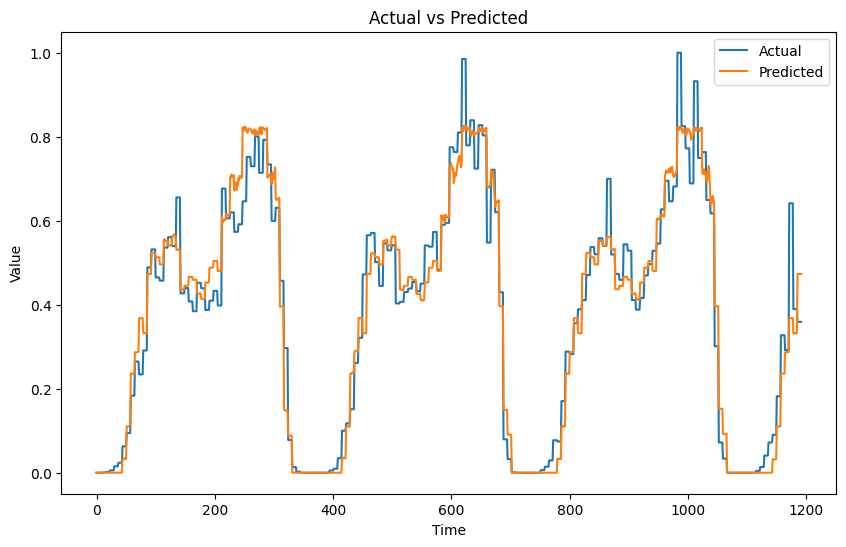

469
469


In [2]:
'''
モデルの推論
'''
# モデルの読み込み
from keras.models import load_model
current_model = load_model('/code/gru_best_model_gru1024_dense1024_loss0.0041.h5')

current_model.summary()

y_pred = current_model.predict(X)
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# 予測結果の計算
y_pred = current_model.predict(X_test)
print(len(y_pred))
# testデータの予測結果をDataFrameに格納
# result = df[['date', 'Week Start', 'Week End', 'Week Number', 'Target']][-469-14:-14]
result = df[['date', 'Week Start', 'Week End', 'Target']][-469-14:-14]
print(len(result))
result['Pred'] = y_pred[:, 0] * df['Target2'].max() * df['Week Status'][-469-14:-14].values
result.to_csv('/code/result.csv', index=False)

<Axes: xlabel='date'>

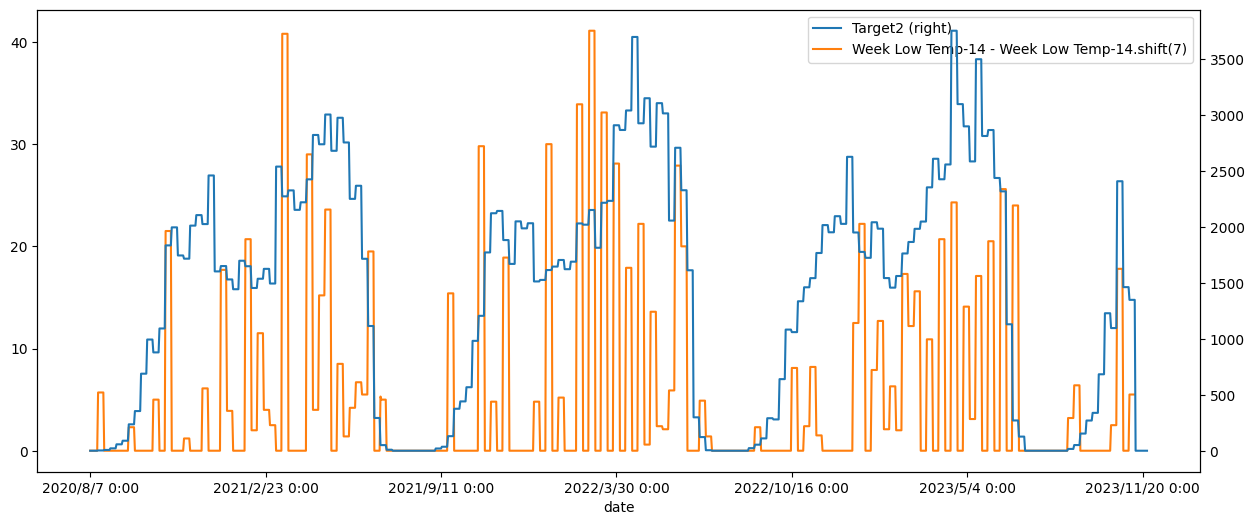

In [43]:
df[['date', 'Target2', 'Week Low Temp-14 - Week Low Temp-14.shift(7)']][:].plot(x='date', secondary_y='Target2', figsize=(15, 6))

## 最新までのデータで推論

/tmp/ipykernel_3229756/2926285015.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['date', 'Week Start', 'Week End', 'Week Status2'], axis=1, inplace=True)


1403 1403
Index(['Target', 'Week Shipment Mean', 'Week Shipment', 'Week Status',
       'Shipment', 'Week GLBRAD-7', 'GLBRAD-7', 'Status', 'Week Number_42',
       'Week Number_39', 'Week Number_41', 'Week Number_43', 'Week Number_40',
       'Week Number_38', 'Week Number_35', 'Week Number_37', 'Week Number_44',
       'Week Number_36', 'Week Number_45', 'Week Temp-14', 'Temp-14',
       'Week Number_46', 'Week Number_20', 'Week Number_34', 'Week Number_33',
       'Week Number_19', 'Week Number_16', 'Week Number_17', 'Week Number_31',
       'Week Number_22', 'Week Number_18', 'Week Number_30', 'Week Number_32',
       'Week Number_15', 'Week Number_21', 'Week Number_25', 'Week Number_26',
       'Week Number_24', 'Week Number_23', 'Week Number_27', 'Week Number_28',
       'Week Number_29', 'Week Number_47', 'Week Number_13', 'Week Number_14',
       'Week Number_12', 'Week Number_11', 'Week Number_53', 'Week Number_48',
       'Week Number_10', 'Week Number_49', 'Week Number_9', 'W

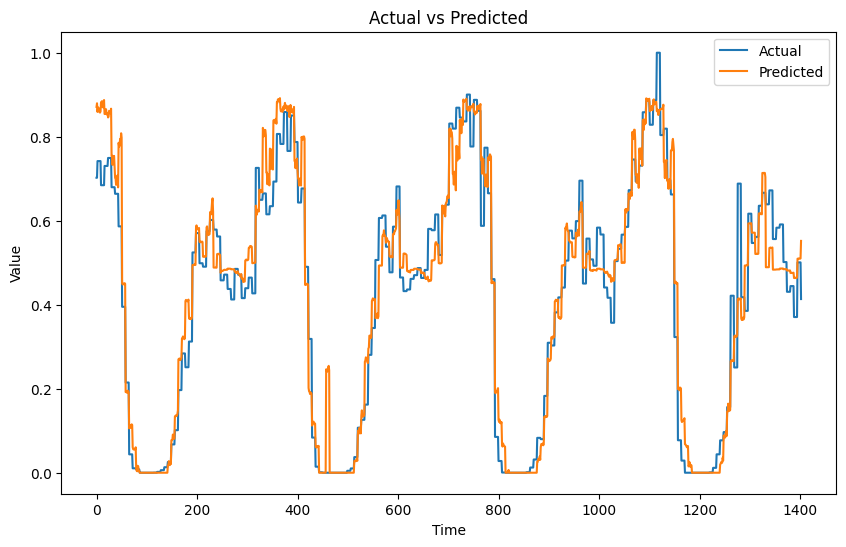

469
469


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, GRU, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

'''
データ読み込み
'''
df = pd.read_csv('/code/data/JA_Dataset.csv')

# 使用する列を選択
df = df[['date', 'Week Start', 'Week End', 'Week Number', 'Shipment',
       'Week Shipment', 'Teisyoku', 'Week Teisyoku', 'Temp', 'Week Temp',
       'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP',
       'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN',
       'Week GLBRAD_30MIN', 'Status', 'Week Status']]

'''
データの前処理
'''
# # dateの値を元にMonth列を作成
# df['Month'] = pd.to_datetime(df['date']).dt.month
# # 1~12月のカテゴリ変数を作成
# df['Month'] = df['Month'].astype('category')
# df = pd.get_dummies(df, columns=['Month'], dtype=int)

# Week Numberのそれぞれの値におけるWeek Shipmentの平均値を取得
Week_Shipment_Mean = df[:1670].groupby('Week Number')['Week Shipment'].mean().reset_index()
# Week Numberの値が等しい行にWeek Shipmentの平均値を結合
df['Week Shipment Mean'] = 0
for i in range(len(Week_Shipment_Mean)):
    df.loc[df['Week Number'] == Week_Shipment_Mean['Week Number'][i], 'Week Shipment Mean'] = Week_Shipment_Mean['Week Shipment'][i]

# Week Shipmentの値が0より大きい場合は1、それ以外は0のWeek Status2を作成
df['Week Status2'] = 0
df.loc[df['Week Shipment'] > 0, 'Week Status2'] = 1

# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINをshiftした列を作成
df['Temp' + str(-14)] = df['Temp'].shift(-14)
df['Week Temp' + str(-14)] = df['Week Temp'].shift(-14)
# df['High Temp' + str(-7)] = df['High Temp'].shift(-14)
# df['Week High Temp' + str(-14)] = df['Week High Temp'].shift(-14)
# df['High Temp' + str(-7)] = df['Low Temp'].shift(-14)
# df['Week Low Temp' + str(-14)] = df['Week Low Temp'].shift(-14)
# df['AIRTMP' + str(-14)] = df['AIRTMP'].shift(-14)
# df['Week AIRTMP' + str(-14)] = df['Week AIRTMP'].shift(-14)
df['GLBRAD' + str(-7)] = df['GLBRAD'].shift(-7)
df['Week GLBRAD' + str(-7)] = df['Week GLBRAD'].shift(-7)
# df['GLBRAD_30MIN' + str(-7)] = df['GLBRAD_30MIN'].shift(-7)
# df['Week GLBRAD_30MIN' + str(-7)] = df['Week GLBRAD_30MIN'].shift(-7)

# Week Status2が0の場合は0とする
df.loc[df['Week Status2'] == 0, 'Temp'] = 0
df.loc[df['Week Status2'] == 0, 'Week Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'High Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'Week High Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'Low Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'Week Low Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'AIRTMP'] = 0
# df.loc[df['Week Status2'] == 0, 'Week AIRTMP'] = 0
df.loc[df['Week Status2'] == 0, 'GLBRAD'] = 0
df.loc[df['Week Status2'] == 0, 'Week GLBRAD'] = 0
# df.loc[df['Week Status2'] == 0, 'GLBRAD_30MIN'] = 0
# df.loc[df['Week Status2'] == 0, 'Week GLBRAD_30MIN'] = 0

# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINを削除
# df = df.drop(['Week Temp', 'Week High Temp', 'Week Low Temp', 'Week AIRTMP', 'Week GLBRAD', 'Week GLBRAD_30MIN'], axis=1)
df = df.drop(['Week Temp', 'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP', 'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD_30MIN'], axis=1)

# 既知のデータを2週間後のものに変更
df['Status'] = df['Status'].shift(-14)
df['Week Status'] = df['Week Status'].shift(-14)
df['Week Shipment Mean'] = df['Week Shipment Mean'].shift(-14)
df['Week Status2'] = df['Week Status2'].shift(-14)

# target列を追加
df['Target'] = df['Week Shipment'].shift(-14)
# Week Shipment列を先週の結果とする
df['Week Shipment'] = df['Week Shipment'].shift(7)

# 0~window_size分だけ各列をシフトし、新しい列として追加する
window_size = 0
shift_columns = ['Temp']
# 元のDataFrameに対して、シフトされた列を一度に追加する
shifted_dfs = [df[shift_columns].shift(i).add_suffix(f'_{i}') for i in range(1, window_size + 1)]
new_df = pd.concat([df] + shifted_dfs, axis=1)
# 新しいDataFrameをコピーして、断片化を解消する
df = new_df.copy()

# Week Numberをカテゴリ変数に変換
df['Week Number'] = df['Week Number'].astype('category')
df = pd.get_dummies(df, columns=['Week Number'], dtype=int)

# 2023年以降のデータを使用
df = df[950:]

# dataに必要な部分だけ抜き出す
data = df[:-14]
data.drop(['date', 'Week Start', 'Week End', 'Week Status2'], axis=1, inplace=True)

'''
モデル入力のための加工（正規化、次元サイズ整理）
'''
scaler = MinMaxScaler()

# ターゲットベクトルの設定
y = df['Target'][window_size:-14].astype(float)
y = scaler.fit_transform(y.values.reshape(-1, 1)[:len(data)]).ravel()

# featuresの各列を正規化
normalized_features = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

print(len(y), len(normalized_features))

# 相関係数の大きい順にならべる
correlations = normalized_features.corrwith(normalized_features['Target'])
correlations = correlations.sort_values(ascending=False)
filtered_features = normalized_features[correlations.index]

# 平均値で欠損値を埋める
filtered_features.fillna(filtered_features.mean(), inplace=True)

# 特徴量をcsvとして保存
filtered_features = filtered_features[['Target', 'Week Shipment Mean', 'Week Shipment', 'Week Status', 'Shipment', 'Week GLBRAD-7', 'GLBRAD-7', 'Status', 'Week Number_42', 'Week Number_39', 'Week Number_41', 'Week Number_43', 'Week Number_40', 'Week Number_38', 'Week Number_35', 'Week Number_37', 'Week Number_44', 'Week Number_36', 'Week Number_45', 'Week Temp-14', 'Temp-14', 'Week Number_46', 'Week Number_20', 'Week Number_34', 'Week Number_33', 'Week Number_19', 'Week Number_16', 'Week Number_17', 'Week Number_31', 'Week Number_22', 'Week Number_18', 'Week Number_30', 'Week Number_32', 'Week Number_15', 'Week Number_21', 'Week Number_25', 'Week Number_26', 'Week Number_24', 'Week Number_23', 'Week Number_27', 'Week Number_28', 'Week Number_29', 'Week Number_47', 'Week Number_13', 'Week Number_14', 'Week Number_12', 'Week Number_11', 'Week Number_53', 'Week Number_48', 'Week Number_10', 'Week Number_49', 'Week Number_9', 'Week Number_50', 'Week Number_8', 'Week Number_51', 'Week Number_1', 'Week Number_52', 'Week Number_2', 'Week Number_7', 'Week Number_6', 'Week Number_5', 'Week Number_4', 'Week Number_3', 'Teisyoku', 'Week Teisyoku']]
filtered_features.to_csv('/code/GRU_features.csv')
print(filtered_features.columns)
print(len(filtered_features.columns))

# Xとyにデータを格納
X = filtered_features.drop('Target', axis=1).values
y = filtered_features['Target'].values

# Xを3次元にリシェイプ
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

X_train = X_reshaped[:-469]
X_test = X_reshaped[-469:]
y_train = y[:-469]
y_test = y[-469:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


'''
モデルの推論
'''
# モデルの読み込み
from keras.models import load_model
current_model = load_model('/code/gru_best_model_gru512_dense512_loss0.0043.h5')

current_model.summary()

y_pred = current_model.predict(X)
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# 予測結果の計算
y_pred = current_model.predict(X_test)
print(len(y_pred))
# testデータの予測結果をDataFrameに格納
# result = df[['date', 'Week Start', 'Week End', 'Week Number', 'Target']][-469-14:-14]
result = df[['date', 'Week Start', 'Week End', 'Target']][-469-14:-14]
print(len(result))
result['Pred'] = y_pred * df['Target'].max()
result.to_csv('/code/result.csv', index=False)

## 3週間後予測モデルの作成

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, GRU, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

'''
データ読み込み
'''
df = pd.read_csv('/code/data/JA_Dataset_240229.csv')

# 使用する列を選択
df = df[['date', 'Week Start', 'Week End', 'Week Number', 'Shipment',
       'Week Shipment', 'Teisyoku', 'Week Teisyoku', 'Temp', 'Week Temp',
       'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP',
       'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN',
       'Week GLBRAD_30MIN', 'Status', 'Week Status']]

'''
データの前処理
'''
# # dateの値を元にMonth列を作成
# df['Month'] = pd.to_datetime(df['date']).dt.month
# # 1~12月のカテゴリ変数を作成
# df['Month'] = df['Month'].astype('category')
# df = pd.get_dummies(df, columns=['Month'], dtype=int)

# Week ShipmentをWeek Statusで割った列を作成
df['Target2'] = df['Week Shipment'] / df['Week Status']
df['Target2'] = df['Target2'].shift(-21)
df['Target2'] = df['Target2'].fillna(0)

# Week Numberのそれぞれの値におけるWeek Shipmentの平均値を取得
Week_Shipment_Mean = df[:1670].groupby('Week Number')['Week Shipment'].mean().reset_index()
# Week Numberの値が等しい行にWeek Shipmentの平均値を結合
df['Week Shipment Mean'] = 0
for i in range(len(Week_Shipment_Mean)):
    df.loc[df['Week Number'] == Week_Shipment_Mean['Week Number'][i], 'Week Shipment Mean'] = Week_Shipment_Mean['Week Shipment'][i]

# Week Shipmentの値が0より大きい場合は1、それ以外は0のWeek Status2を作成
df['Week Status2'] = 0
df.loc[df['Week Shipment'] > 0, 'Week Status2'] = 1

# 既知のデータを3週間後のものに変更
df['Status'] = df['Status'].shift(-21)
df['Week Status'] = df['Week Status'].shift(-21)
df['Week Shipment Mean'] = df['Week Shipment Mean'].shift(-21)
df['Week Status2'] = df['Week Status2'].shift(-21)

# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINをshiftした列を作成
df['Temp' + str(-21)] = df['Temp'].shift(-21)
df['Week Temp' + str(-21)] = df['Week Temp'].shift(-21)
# df['High Temp' + str(-7)] = df['High Temp'].shift(-14)
# df['Week High Temp' + str(-14)] = df['Week High Temp'].shift(-14)
# df['High Temp' + str(-7)] = df['Low Temp'].shift(-14)
# df['Week Low Temp' + str(-14)] = df['Week Low Temp'].shift(-14)
# df['AIRTMP' + str(-14)] = df['AIRTMP'].shift(-14)
# df['Week AIRTMP' + str(-14)] = df['Week AIRTMP'].shift(-14)
# df['GLBRAD' + str(-7)] = df['GLBRAD'].shift(-7)
# df['Week GLBRAD' + str(-7)] = df['Week GLBRAD'].shift(-7)
# df['GLBRAD_30MIN' + str(-7)] = df['GLBRAD_30MIN'].shift(-7)
# df['Week GLBRAD_30MIN' + str(-7)] = df['Week GLBRAD_30MIN'].shift(-7)

# Week Low Tempの前週との差をとった列を作成
# df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] = (df['Week Low Temp-14'] - df['Week Low Temp-14'].shift(7))
# df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] = (df['Week Low Temp-14'] - df['Week Low Temp-14'].shift(7)) / abs(df['Week Low Temp-14'].shift(7))
# 負の値と1以上の値を0で置換
# df.loc[df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] < 0, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0
# df.loc[df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] > 1, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0
# Week Numberが25以上の場合は0
# df.loc[df['Week Number'] >= 20, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0

# Week Status2が0の場合は0とする
df.loc[df['Week Status2'] == 0, 'Temp-21'] = 0
df.loc[df['Week Status2'] == 0, 'Week Temp-21'] = 0
# df.loc[df['Week Status2'] == 0, 'High Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'Week High Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'Low Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'Week Low Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'AIRTMP'] = 0
# df.loc[df['Week Status2'] == 0, 'Week AIRTMP'] = 0
# df.loc[df['Week Status2'] == 0, 'GLBRAD-14'] = 0
# df.loc[df['Week Status2'] == 0, 'Week GLBRAD-14'] = 0
# df.loc[df['Week Status2'] == 0, 'GLBRAD_30MIN'] = 0
# df.loc[df['Week Status2'] == 0, 'Week GLBRAD_30MIN'] = 0
# df.loc[df['Week Status2'] == 0, 'Week Low Temp-21 - Week Low Temp-21.shift(7)'] = 0

# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINを削除
# df = df.drop(['Week Temp', 'Week High Temp', 'Week Low Temp', 'Week AIRTMP', 'Week GLBRAD', 'Week GLBRAD_30MIN'], axis=1)
# df = df.drop(['Temp', 'Week Temp', 'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'Week Low Temp-14', 'AIRTMP', 'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD_30MIN'], axis=1)
df = df.drop(['Temp', 'Week Temp', 'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP', 'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD_30MIN'], axis=1)

# target列を追加
df['Target'] = df['Week Shipment'].shift(-21)
# Week Shipment列を先週の結果とする
df['Week Shipment'] = df['Week Shipment'].shift(7)

# 0~window_size分だけ各列をシフトし、新しい列として追加する
window_size = 0
shift_columns = ['Temp']
# 元のDataFrameに対して、シフトされた列を一度に追加する
shifted_dfs = [df[shift_columns].shift(i).add_suffix(f'_{i}') for i in range(1, window_size + 1)]
new_df = pd.concat([df] + shifted_dfs, axis=1)
# 新しいDataFrameをコピーして、断片化を解消する
df = new_df.copy()

# Week Numberをカテゴリ変数に変換
df['Week Number'] = df['Week Number'].astype('category')
df = pd.get_dummies(df, columns=['Week Number'], dtype=int)

# 2019年以降のデータを使用
df = df[950:]

# dataに必要な部分だけ抜き出す
data = df[:-21]
# data.drop(['date', 'Week Start', 'Week End', 'Target', 'Week Status2', 'Status', 'Teisyoku', 'Week Teisyoku', 'GLBRAD-14', 'Week GLBRAD-14', 'Week Low Temp-21 - Week Low Temp-21.shift(7)'], axis=1, inplace=True)
data.drop(['date', 'Week Start', 'Week End', 'Target', 'Week Status', 'Week Status2', 'Status', 'Teisyoku', 'Week Teisyoku'], axis=1, inplace=True)

'''
モデル入力のための加工（正規化、次元サイズ整理）
'''
scaler = MinMaxScaler()

# ターゲットベクトルの設定
y = df['Target2'][window_size:-21].astype(float)
y = scaler.fit_transform(y.values.reshape(-1, 1)[:len(data)]).ravel()

# featuresの各列を正規化
normalized_features = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

print(len(y), len(normalized_features))

# 相関係数の大きい順にならべる
correlations = normalized_features.corrwith(normalized_features['Target2'])
correlations = correlations.sort_values(ascending=False)
filtered_features = normalized_features[correlations.index]

# 平均値で欠損値を埋める
filtered_features.fillna(filtered_features.mean(), inplace=True)

# 特徴量をcsvとして保存
# filtered_features = filtered_features[['Target2', 'Week Shipment', 'Shipment', 'Week GLBRAD-7', 'GLBRAD-7', 'Week Number_42', 'Week Number_39', 'Week Number_41', 'Week Number_43', 'Week Number_40', 'Week Number_38', 'Week Number_35', 'Week Number_37', 'Week Number_44', 'Week Number_36', 'Week Number_45', 'Week Temp-14', 'Temp-14', 'Week Number_46', 'Week Number_20', 'Week Number_34', 'Week Number_33', 'Week Number_19', 'Week Number_16', 'Week Number_17', 'Week Number_31', 'Week Number_22', 'Week Number_18', 'Week Number_30', 'Week Number_32', 'Week Number_15', 'Week Number_21', 'Week Number_25', 'Week Number_26', 'Week Number_24', 'Week Number_23', 'Week Number_27', 'Week Number_28', 'Week Number_29', 'Week Number_47', 'Week Number_13', 'Week Number_14', 'Week Number_12', 'Week Number_11', 'Week Number_53', 'Week Number_48', 'Week Number_10', 'Week Number_49', 'Week Number_9', 'Week Number_50', 'Week Number_8', 'Week Number_51', 'Week Number_1', 'Week Number_52', 'Week Number_2', 'Week Number_7', 'Week Number_6', 'Week Number_5', 'Week Number_4', 'Week Number_3']]
filtered_features.to_csv('/code/GRU_features.csv')
print(filtered_features.columns)

# Xとyにデータを格納
X = filtered_features.drop('Target2', axis=1).values
y = filtered_features['Target2'].values

# Xを3次元にリシェイプ
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

X_train = X_reshaped[:-469]
X_test = X_reshaped[-469:]
y_train = y[:-469]
y_test = y[-469:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


'''
モデルの訓練
'''
def train_and_evaluate_model(gru_units, dense_units):
    # model = Sequential()
    # model.add(GRU(units=gru_units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dense(units=dense_units, activation='relu'))
    # model.add(Dense(1, activation='relu'))
    # model.compile(optimizer='adam', loss='mean_squared_error')

    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    dense_layer = Dense(units=dense_units, activation='relu')(input_layer)
    gru_layer = GRU(units=gru_units, return_sequences=False)(dense_layer)
    output_layer = Dense(1, activation='relu')(gru_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, min_lr=0.000000001)

    # モデルの訓練
    history = model.fit(X_train, y_train, epochs=10000, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)
    
    # 検証データでの損失を評価
    val_loss = model.evaluate(X_test, y_test)
    print(f"GRU Units: {gru_units}, Dense Units: {dense_units}, Validation Loss: {val_loss}")

    return model, gru_units, dense_units, val_loss

# 結果を格納するための空のリストを作成
results = []
n = 1 # 繰り返しの回数

# 最良のモデルを追跡するための変数
best_params = {'gru_units': None, 'dense_units': None, 'val_loss': float('inf')}
best_model = None

# 異なるハイパーパラメータの組み合わせでモデルを訓練し評価
# for gru_units in [16, 32, 64, 128, 256]:
#     for dense_units in [16, 32, 64, 128, 256]:
#         val_loss = 99999999
#         for i in range(n):
#             result = train_and_evaluate_model(gru_units, dense_units)
#             print(result)
#             if val_loss > result[3]:
#                 val_loss = result[3]
#                 # 最良のモデルを更新
#                 if val_loss < best_params['val_loss']:
#                     best_params['gru_units'] = gru_units
#                     best_params['dense_units'] = dense_units
#                     best_params['val_loss'] = val_loss
#                     best_model = result[0]
#             print(f'val_loss: {val_loss}')
#         results.append(result)

for gru_units in [256, 512, 1024]:
    for dense_units in [256, 512, 1024]:
        val_loss = 99999999
        for i in range(n):
            result = train_and_evaluate_model(gru_units, dense_units)
            print(result)
            if val_loss > result[3]:
                val_loss = result[3]
                # 最良のモデルを更新
                if val_loss < best_params['val_loss']:
                    best_params['gru_units'] = gru_units
                    best_params['dense_units'] = dense_units
                    best_params['val_loss'] = val_loss
                    best_model = result[0]
            print(f'val_loss: {val_loss}')
        results.append(result)

print(results)

# 結果をDataFrameに変換
results_df = pd.DataFrame(results, columns=['model', 'GRU Units', 'Dense Units', 'Validation Loss'])

# 結果をCSVファイルに書き込む
results_df.to_csv('/code/gru_performance.csv', index=False)

# 最良のモデルのパラメータをファイル名に含めて保存
filename = f'/code/gru_best_model_gru{best_params["gru_units"]}_dense{best_params["dense_units"]}_loss{best_params["val_loss"]:.4f}.h5'
best_model.save(filename)

print(f"Saved the best model's results to {filename}")

/tmp/ipykernel_1305722/740646661.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['date', 'Week Start', 'Week End', 'Target', 'Week Status', 'Week Status2', 'Status', 'Teisyoku', 'Week Teisyoku'], axis=1, inplace=True)


1185 1185
Index(['Target2', 'Week Shipment Mean', 'Week Shipment', 'Shipment',
       'Week Number_37', 'Week Number_41', 'Week Number_38', 'Week Number_42',
       'Week Number_39', 'Week Number_40', 'Week Number_34', 'Week Number_36',
       'Week Number_43', 'Week Number_35', 'Week Number_44', 'Week Number_45',
       'Week Temp-21', 'Week Number_33', 'Temp-21', 'Week Number_32',
       'Week Number_20', 'Week Number_18', 'Week Number_19', 'Week Number_21',
       'Week Number_15', 'Week Number_16', 'Week Number_30', 'Week Number_17',
       'Week Number_29', 'Week Number_31', 'Week Number_14', 'Week Number_24',
       'Week Number_25', 'Week Number_28', 'Week Number_23', 'Week Number_22',
       'Week Number_26', 'Week Number_27', 'Week Number_46', 'Week Number_12',
       'Week Number_13', 'Week Number_11', 'Week Number_10', 'Week Number_53',
       'Week Number_47', 'Week Number_9', 'Week Number_48', 'Week Number_8',
       'Week Number_49', 'Week Number_50', 'Week Number_1', 'We

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 58, 1)]           0         
                                                                 
 dense_64 (Dense)            (None, 58, 1024)          2048      
                                                                 
 gru_32 (GRU)                (None, 512)               2362368   
                                                                 
 dense_65 (Dense)            (None, 1)                 513       
                                                                 
Total params: 2,364,929
Trainable params: 2,364,929
Non-trainable params: 0
_________________________________________________________________


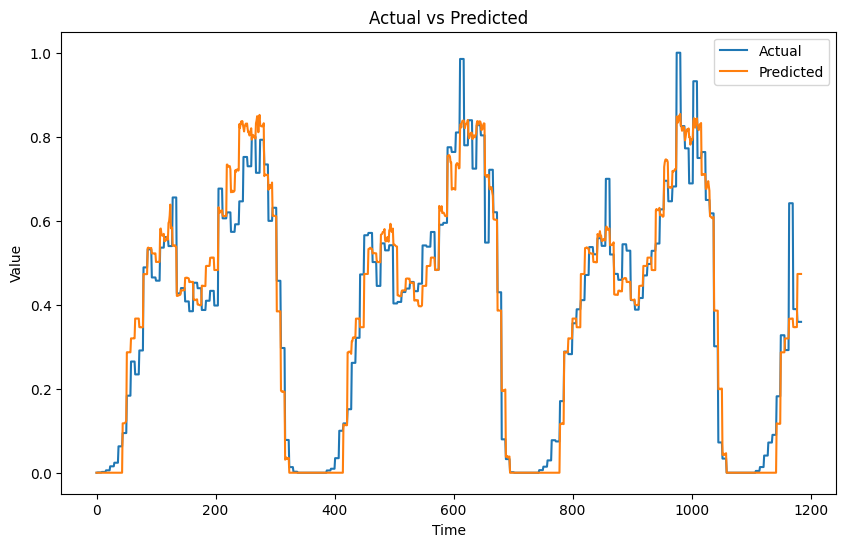

469
469


In [11]:
'''
モデルの推論
'''
# モデルの読み込み
from keras.models import load_model
current_model = load_model('/code/gru_best_model_gru512_dense1024_loss0.0039.h5')

current_model.summary()

y_pred = current_model.predict(X)
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# 予測結果の計算
y_pred = current_model.predict(X_test)
print(len(y_pred))
# testデータの予測結果をDataFrameに格納
# result = df[['date', 'Week Start', 'Week End', 'Week Number', 'Target']][-469-14:-14]
result = df[['date', 'Week Start', 'Week End', 'Target']][-469-21:-21]
print(len(result))
result['Pred'] = y_pred[:, 0] * df['Target2'].max() * df['Week Status'][-469-21:-21].values
result.to_csv('/code/result.csv', index=False)

<Axes: xlabel='date'>

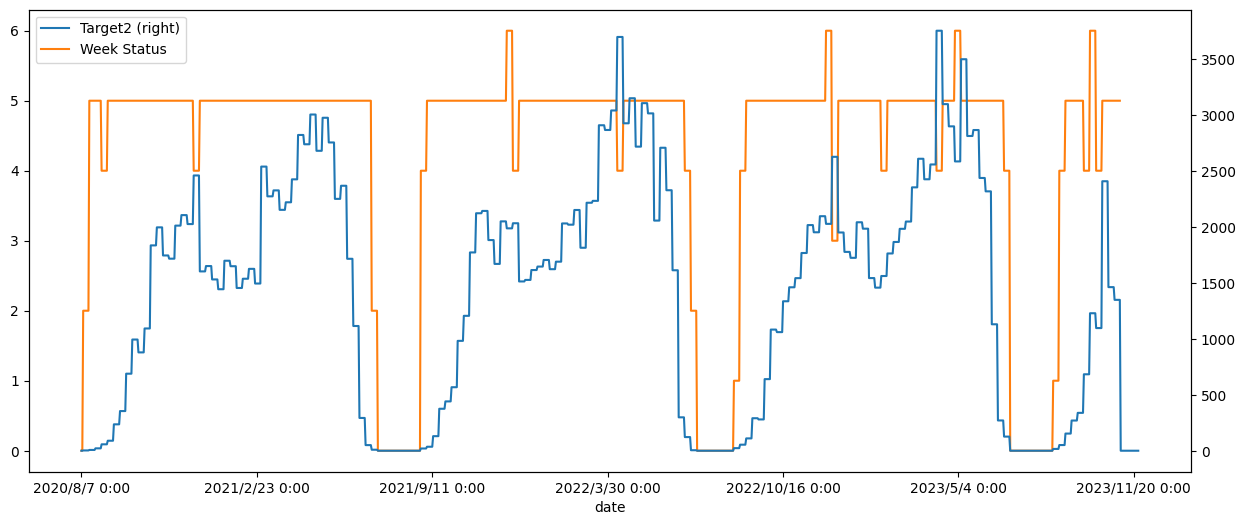

In [9]:
df[['date', 'Target2', 'Week Status']][:].plot(x='date', secondary_y='Target2', figsize=(15, 6))

## 1週間後予測モデルの作成

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, GRU, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

'''
データ読み込み
'''
df = pd.read_csv('/code/data/JA_Dataset_240229.csv')

# 使用する列を選択
df = df[['date', 'Week Start', 'Week End', 'Week Number', 'Shipment',
       'Week Shipment', 'Teisyoku', 'Week Teisyoku', 'Temp', 'Week Temp',
       'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP',
       'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN',
       'Week GLBRAD_30MIN', 'Status', 'Week Status']]

'''
データの前処理
'''
# # dateの値を元にMonth列を作成
# df['Month'] = pd.to_datetime(df['date']).dt.month
# # 1~12月のカテゴリ変数を作成
# df['Month'] = df['Month'].astype('category')
# df = pd.get_dummies(df, columns=['Month'], dtype=int)

# Week ShipmentをWeek Statusで割った列を作成
df['Target2'] = df['Week Shipment'] / df['Week Status']
df['Target2'] = df['Target2'].shift(-7)
df['Target2'] = df['Target2'].fillna(0)

# Week Numberのそれぞれの値におけるWeek Shipmentの平均値を取得
Week_Shipment_Mean = df[:1670].groupby('Week Number')['Week Shipment'].mean().reset_index()
# Week Numberの値が等しい行にWeek Shipmentの平均値を結合
df['Week Shipment Mean'] = 0
for i in range(len(Week_Shipment_Mean)):
    df.loc[df['Week Number'] == Week_Shipment_Mean['Week Number'][i], 'Week Shipment Mean'] = Week_Shipment_Mean['Week Shipment'][i]

# Week Shipmentの値が0より大きい場合は1、それ以外は0のWeek Status2を作成
df['Week Status2'] = 0
df.loc[df['Week Shipment'] > 0, 'Week Status2'] = 1

# 既知のデータを3週間後のものに変更
df['Status'] = df['Status'].shift(-7)
df['Week Status'] = df['Week Status'].shift(-7)
df['Week Shipment Mean'] = df['Week Shipment Mean'].shift(-7)
df['Week Status2'] = df['Week Status2'].shift(-7)

# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINをshiftした列を作成
df['Temp' + str(-7)] = df['Temp'].shift(-7)
df['Week Temp' + str(-7)] = df['Week Temp'].shift(-7)
# df['High Temp' + str(-7)] = df['High Temp'].shift(-14)
# df['Week High Temp' + str(-14)] = df['Week High Temp'].shift(-14)
# df['High Temp' + str(-7)] = df['Low Temp'].shift(-14)
# df['Week Low Temp' + str(-14)] = df['Week Low Temp'].shift(-14)
# df['AIRTMP' + str(-14)] = df['AIRTMP'].shift(-14)
# df['Week AIRTMP' + str(-14)] = df['Week AIRTMP'].shift(-14)
# df['GLBRAD' + str(-7)] = df['GLBRAD'].shift(-7)
# df['Week GLBRAD' + str(-7)] = df['Week GLBRAD'].shift(-7)
# df['GLBRAD_30MIN' + str(-7)] = df['GLBRAD_30MIN'].shift(-7)
# df['Week GLBRAD_30MIN' + str(-7)] = df['Week GLBRAD_30MIN'].shift(-7)

# Week Low Tempの前週との差をとった列を作成
# df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] = (df['Week Low Temp-14'] - df['Week Low Temp-14'].shift(7))
# df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] = (df['Week Low Temp-14'] - df['Week Low Temp-14'].shift(7)) / abs(df['Week Low Temp-14'].shift(7))
# 負の値と1以上の値を0で置換
# df.loc[df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] < 0, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0
# df.loc[df['Week Low Temp-14 - Week Low Temp-14.shift(7)'] > 1, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0
# Week Numberが25以上の場合は0
# df.loc[df['Week Number'] >= 20, 'Week Low Temp-14 - Week Low Temp-14.shift(7)'] = 0

# Week Status2が0の場合は0とする
df.loc[df['Week Status2'] == 0, 'Temp-7'] = 0
df.loc[df['Week Status2'] == 0, 'Week Temp-7'] = 0
# df.loc[df['Week Status2'] == 0, 'High Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'Week High Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'Low Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'Week Low Temp'] = 0
# df.loc[df['Week Status2'] == 0, 'AIRTMP'] = 0
# df.loc[df['Week Status2'] == 0, 'Week AIRTMP'] = 0
# df.loc[df['Week Status2'] == 0, 'GLBRAD-14'] = 0
# df.loc[df['Week Status2'] == 0, 'Week GLBRAD-14'] = 0
# df.loc[df['Week Status2'] == 0, 'GLBRAD_30MIN'] = 0
# df.loc[df['Week Status2'] == 0, 'Week GLBRAD_30MIN'] = 0
# df.loc[df['Week Status2'] == 0, 'Week Low Temp-21 - Week Low Temp-21.shift(7)'] = 0

# Week Temp, Week High Temp, Week Low Temp, Week AIRTMP, Week GLBRAD, Week GLBRAD_30MINを削除
# df = df.drop(['Week Temp', 'Week High Temp', 'Week Low Temp', 'Week AIRTMP', 'Week GLBRAD', 'Week GLBRAD_30MIN'], axis=1)
# df = df.drop(['Temp', 'Week Temp', 'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'Week Low Temp-14', 'AIRTMP', 'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD_30MIN'], axis=1)
df = df.drop(['Temp', 'Week Temp', 'High Temp', 'Week High Temp', 'Low Temp', 'Week Low Temp', 'AIRTMP', 'Week AIRTMP', 'GLBRAD', 'Week GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD_30MIN'], axis=1)

# target列を追加
df['Target'] = df['Week Shipment'].shift(-7)
# Week Shipment列を先週の結果とする
df['Week Shipment'] = df['Week Shipment'].shift(7)

# 0~window_size分だけ各列をシフトし、新しい列として追加する
window_size = 0
shift_columns = ['Temp']
# 元のDataFrameに対して、シフトされた列を一度に追加する
shifted_dfs = [df[shift_columns].shift(i).add_suffix(f'_{i}') for i in range(1, window_size + 1)]
new_df = pd.concat([df] + shifted_dfs, axis=1)
# 新しいDataFrameをコピーして、断片化を解消する
df = new_df.copy()

# Week Numberをカテゴリ変数に変換
df['Week Number'] = df['Week Number'].astype('category')
df = pd.get_dummies(df, columns=['Week Number'], dtype=int)

# 2019年以降のデータを使用
df = df[950:]

# dataに必要な部分だけ抜き出す
data = df[:-7]
# data.drop(['date', 'Week Start', 'Week End', 'Target', 'Week Status2', 'Status', 'Teisyoku', 'Week Teisyoku', 'GLBRAD-14', 'Week GLBRAD-14', 'Week Low Temp-21 - Week Low Temp-21.shift(7)'], axis=1, inplace=True)
data.drop(['date', 'Week Start', 'Week End', 'Target', 'Week Status2', 'Status', 'Teisyoku', 'Week Teisyoku'], axis=1, inplace=True)

'''
モデル入力のための加工（正規化、次元サイズ整理）
'''
scaler = MinMaxScaler()

# ターゲットベクトルの設定
y = df['Target2'][window_size:-7].astype(float)
y = scaler.fit_transform(y.values.reshape(-1, 1)[:len(data)]).ravel()

# featuresの各列を正規化
normalized_features = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

print(len(y), len(normalized_features))

# 相関係数の大きい順にならべる
correlations = normalized_features.corrwith(normalized_features['Target2'])
correlations = correlations.sort_values(ascending=False)
filtered_features = normalized_features[correlations.index]

# 平均値で欠損値を埋める
filtered_features.fillna(filtered_features.mean(), inplace=True)

# 特徴量をcsvとして保存
# filtered_features = filtered_features[['Target2', 'Week Shipment', 'Shipment', 'Week GLBRAD-7', 'GLBRAD-7', 'Week Number_42', 'Week Number_39', 'Week Number_41', 'Week Number_43', 'Week Number_40', 'Week Number_38', 'Week Number_35', 'Week Number_37', 'Week Number_44', 'Week Number_36', 'Week Number_45', 'Week Temp-14', 'Temp-14', 'Week Number_46', 'Week Number_20', 'Week Number_34', 'Week Number_33', 'Week Number_19', 'Week Number_16', 'Week Number_17', 'Week Number_31', 'Week Number_22', 'Week Number_18', 'Week Number_30', 'Week Number_32', 'Week Number_15', 'Week Number_21', 'Week Number_25', 'Week Number_26', 'Week Number_24', 'Week Number_23', 'Week Number_27', 'Week Number_28', 'Week Number_29', 'Week Number_47', 'Week Number_13', 'Week Number_14', 'Week Number_12', 'Week Number_11', 'Week Number_53', 'Week Number_48', 'Week Number_10', 'Week Number_49', 'Week Number_9', 'Week Number_50', 'Week Number_8', 'Week Number_51', 'Week Number_1', 'Week Number_52', 'Week Number_2', 'Week Number_7', 'Week Number_6', 'Week Number_5', 'Week Number_4', 'Week Number_3']]
filtered_features.to_csv('/code/GRU_features.csv')
print(filtered_features.columns)

# Xとyにデータを格納
X = filtered_features.drop('Target2', axis=1).values
y = filtered_features['Target2'].values

# Xを3次元にリシェイプ
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

X_train = X_reshaped[:-469]
X_test = X_reshaped[-469:]
y_train = y[:-469]
y_test = y[-469:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


'''
モデルの訓練
'''
def train_and_evaluate_model(gru_units, dense_units):
    # model = Sequential()
    # model.add(GRU(units=gru_units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dense(units=dense_units, activation='relu'))
    # model.add(Dense(1, activation='relu'))
    # model.compile(optimizer='adam', loss='mean_squared_error')

    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    dense_layer = Dense(units=dense_units, activation='relu')(input_layer)
    gru_layer = GRU(units=gru_units, return_sequences=False)(dense_layer)
    output_layer = Dense(1, activation='relu')(gru_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, min_lr=0.000000001)

    # モデルの訓練
    history = model.fit(X_train, y_train, epochs=10000, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)
    
    # 検証データでの損失を評価
    val_loss = model.evaluate(X_test, y_test)
    print(f"GRU Units: {gru_units}, Dense Units: {dense_units}, Validation Loss: {val_loss}")

    return model, gru_units, dense_units, val_loss

# 結果を格納するための空のリストを作成
results = []
n = 1 # 繰り返しの回数

# 最良のモデルを追跡するための変数
best_params = {'gru_units': None, 'dense_units': None, 'val_loss': float('inf')}
best_model = None

# 異なるハイパーパラメータの組み合わせでモデルを訓練し評価
# for gru_units in [16, 32, 64, 128, 256]:
#     for dense_units in [16, 32, 64, 128, 256]:
#         val_loss = 99999999
#         for i in range(n):
#             result = train_and_evaluate_model(gru_units, dense_units)
#             print(result)
#             if val_loss > result[3]:
#                 val_loss = result[3]
#                 # 最良のモデルを更新
#                 if val_loss < best_params['val_loss']:
#                     best_params['gru_units'] = gru_units
#                     best_params['dense_units'] = dense_units
#                     best_params['val_loss'] = val_loss
#                     best_model = result[0]
#             print(f'val_loss: {val_loss}')
#         results.append(result)

for gru_units in [256, 512, 1024]:
    for dense_units in [256, 512, 1024]:
        val_loss = 99999999
        for i in range(n):
            result = train_and_evaluate_model(gru_units, dense_units)
            print(result)
            if val_loss > result[3]:
                val_loss = result[3]
                # 最良のモデルを更新
                if val_loss < best_params['val_loss']:
                    best_params['gru_units'] = gru_units
                    best_params['dense_units'] = dense_units
                    best_params['val_loss'] = val_loss
                    best_model = result[0]
            print(f'val_loss: {val_loss}')
        results.append(result)

print(results)

# 結果をDataFrameに変換
results_df = pd.DataFrame(results, columns=['model', 'GRU Units', 'Dense Units', 'Validation Loss'])

# 結果をCSVファイルに書き込む
results_df.to_csv('/code/gru_performance.csv', index=False)

# 最良のモデルのパラメータをファイル名に含めて保存
filename = f'/code/gru_best_model_gru{best_params["gru_units"]}_dense{best_params["dense_units"]}_loss{best_params["val_loss"]:.4f}.h5'
best_model.save(filename)

print(f"Saved the best model's results to {filename}")

/tmp/ipykernel_1305722/2490189399.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['date', 'Week Start', 'Week End', 'Target', 'Week Status2', 'Status', 'Teisyoku', 'Week Teisyoku'], axis=1, inplace=True)


1199 1199
Index(['Target2', 'Week Shipment Mean', 'Week Shipment', 'Shipment',
       'Week Status', 'Week Number_39', 'Week Number_43', 'Week Number_40',
       'Week Number_44', 'Week Number_41', 'Week Number_42', 'Week Number_36',
       'Week Number_38', 'Week Number_45', 'Week Number_37', 'Week Temp-7',
       'Week Number_46', 'Temp-7', 'Week Number_47', 'Week Number_35',
       'Week Number_34', 'Week Number_22', 'Week Number_20', 'Week Number_21',
       'Week Number_23', 'Week Number_17', 'Week Number_18', 'Week Number_32',
       'Week Number_19', 'Week Number_31', 'Week Number_33', 'Week Number_16',
       'Week Number_26', 'Week Number_27', 'Week Number_30', 'Week Number_25',
       'Week Number_24', 'Week Number_28', 'Week Number_29', 'Week Number_48',
       'Week Number_14', 'Week Number_15', 'Week Number_13', 'Week Number_12',
       'Week Number_53', 'Week Number_49', 'Week Number_11', 'Week Number_50',
       'Week Number_10', 'Week Number_51', 'Week Number_52', 'Week

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 59, 1)]           0         
                                                                 
 dense_82 (Dense)            (None, 59, 1024)          2048      
                                                                 
 gru_41 (GRU)                (None, 512)               2362368   
                                                                 
 dense_83 (Dense)            (None, 1)                 513       
                                                                 
Total params: 2,364,929
Trainable params: 2,364,929
Non-trainable params: 0
_________________________________________________________________


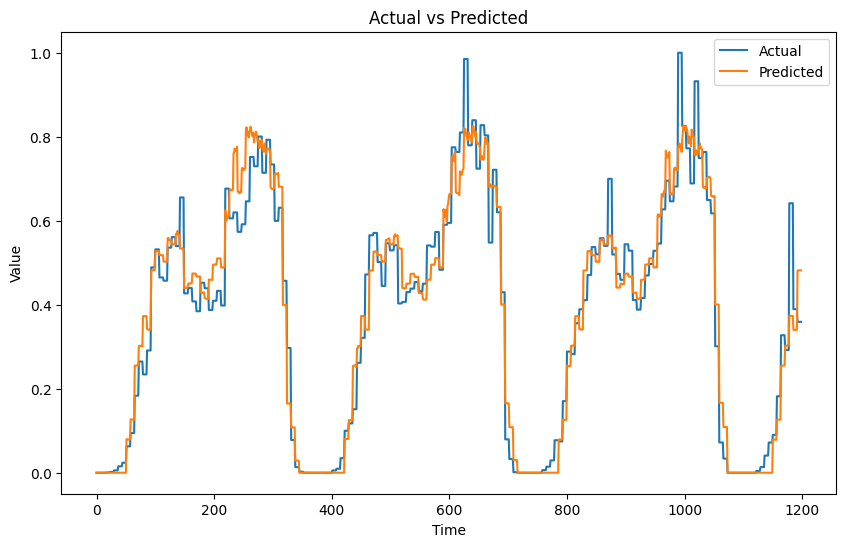

469
469


In [13]:
'''
モデルの推論
'''
# モデルの読み込み
from keras.models import load_model
current_model = load_model('/code/gru_best_model_gru512_dense1024_loss0.0045.h5')

current_model.summary()

y_pred = current_model.predict(X)
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# 予測結果の計算
y_pred = current_model.predict(X_test)
print(len(y_pred))
# testデータの予測結果をDataFrameに格納
# result = df[['date', 'Week Start', 'Week End', 'Week Number', 'Target']][-469-14:-14]
result = df[['date', 'Week Start', 'Week End', 'Target']][-469-7:-7]
print(len(result))
result['Pred'] = y_pred[:, 0] * df['Target2'].max() * df['Week Status'][-469-7:-7].values
result.to_csv('/code/result.csv', index=False)